# Hand Engineered Features - HOG feature from Chest radiographs.



***Steps to get started***

Execute this notebook in Kaggle. 
Login to Kaggle account and click on "New Notebook".
From File menu, select "Import notebook", and drag and drop this notebook file to it.
Click on any cell to start session.
On the right pane, you will find "Add Data" . On the search icon give the below url (of the dataset) and select this dataset from the search results. Click the "+" icon to add this dataset to your notebook session.

Dataset - https://www.kaggle.com/datasets/kmader/pulmonary-chest-xray-abnormalities

In [2]:
# Importing the libraries

import pandas as pd
import numpy as np

import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import seaborn as sns
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split


warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



In [3]:
os.listdir('../input')

['pulmonary-chest-xray-abnormalities']

In [4]:
os.listdir('../input/pulmonary-chest-xray-abnormalities')

['ChinaSet_AllFiles', 'Montgomery']

In [5]:
shen_image_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
mont_image_list = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

In [6]:
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])

In [7]:
df_shen.head

<bound method NDFrame.head of               image_id
0    CHNCXR_0092_0.png
1    CHNCXR_0322_0.png
2    CHNCXR_0304_0.png
3    CHNCXR_0572_1.png
4    CHNCXR_0547_1.png
..                 ...
658  CHNCXR_0321_0.png
659  CHNCXR_0080_0.png
660  CHNCXR_0569_1.png
661  CHNCXR_0107_0.png
662  CHNCXR_0054_0.png

[663 rows x 1 columns]>

In [8]:
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_shen

,image_id
0,CHNCXR_0092_0.png
1,CHNCXR_0322_0.png
2,CHNCXR_0304_0.png
3,CHNCXR_0572_1.png
4,CHNCXR_0547_1.png
...,...
658,CHNCXR_0321_0.png
659,CHNCXR_0080_0.png
660,CHNCXR_0569_1.png
661,CHNCXR_0107_0.png


In [9]:
df_shen.head

<bound method NDFrame.head of               image_id
0    CHNCXR_0092_0.png
1    CHNCXR_0322_0.png
2    CHNCXR_0304_0.png
3    CHNCXR_0572_1.png
4    CHNCXR_0547_1.png
..                 ...
658  CHNCXR_0321_0.png
659  CHNCXR_0080_0.png
660  CHNCXR_0569_1.png
661  CHNCXR_0107_0.png
662  CHNCXR_0054_0.png

[662 rows x 1 columns]>

In [10]:
# put the images into dataframes
df_shen = pd.DataFrame(shen_image_list, columns=['image_id'])
df_mont = pd.DataFrame(mont_image_list, columns=['image_id'])

# remove the 'Thunbs.db' line
df_shen = df_shen[df_shen['image_id'] != 'Thumbs.db']
df_mont = df_mont[df_mont['image_id'] != 'Thumbs.db']

# Reset the index or this will cause an error later
df_shen.reset_index(inplace=True, drop=True)
df_mont.reset_index(inplace=True, drop=True)

print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [11]:
df_shen.head()

,image_id
0,CHNCXR_0092_0.png
1,CHNCXR_0322_0.png
2,CHNCXR_0304_0.png
3,CHNCXR_0572_1.png
4,CHNCXR_0547_1.png


In [12]:
df_mont.head()

,image_id
0,MCUCXR_0017_0.png
1,MCUCXR_0020_0.png
2,MCUCXR_0030_0.png
3,MCUCXR_0013_0.png
4,MCUCXR_0354_1.png


In [13]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [14]:
# Assign the target labels

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)

In [15]:
# Shenzen Dataset

df_shen['target'].value_counts()

Tuberculosis    336
Normal          326
Name: target, dtype: int64

In [16]:
# Montgomery Dataset

df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

Function to display the images in datasets

In [17]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

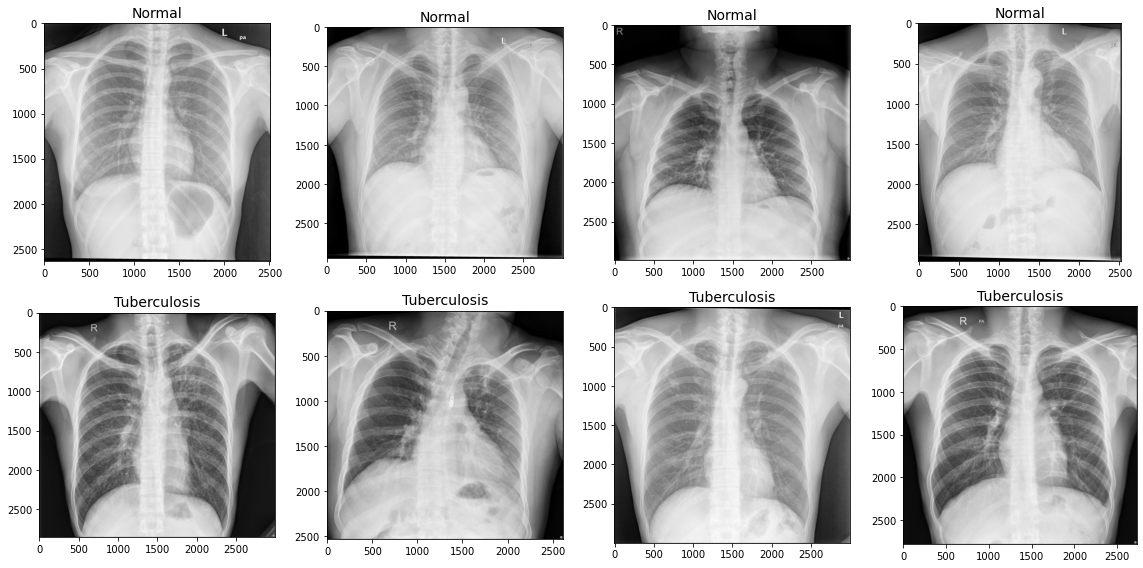

In [18]:
# Shenzen Dataset

IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/' 

draw_category_images('target',4, df_shen, IMAGE_PATH)

Visualizing the montgomer dataset images

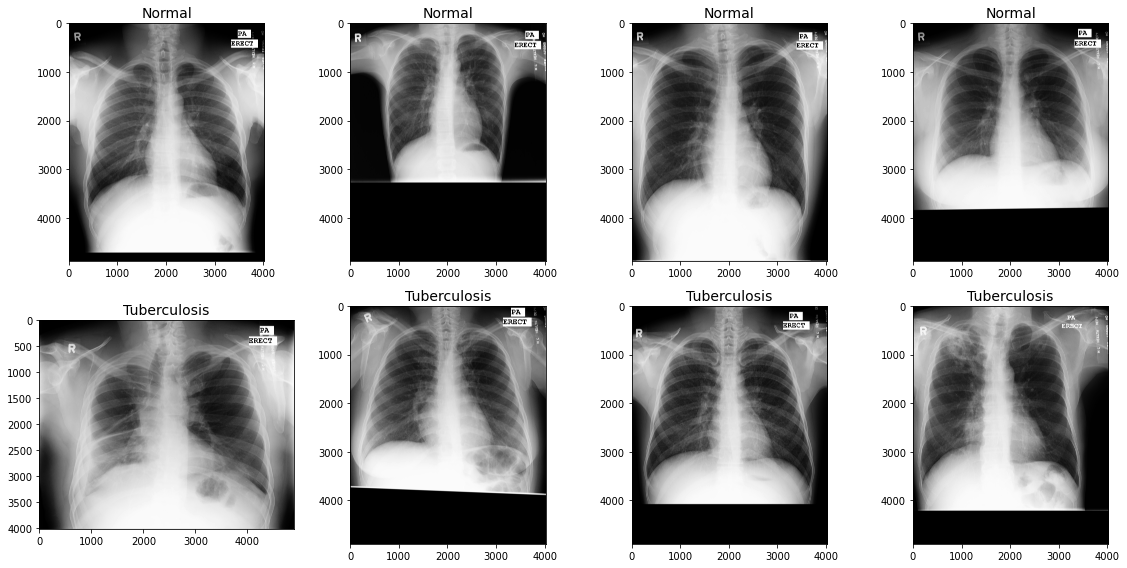

In [19]:
# Montgomery Dataset

IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

# EDA Exploratory Data Analysis

In [20]:
#EDA

def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output


In [21]:
# w = width, h= height, c= number of channels of image
IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png/'

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0092_0.png,Normal,2652,2796,3,255,0
1,CHNCXR_0322_0.png,Normal,2949,3000,3,255,0
2,CHNCXR_0304_0.png,Normal,2945,3000,3,255,0
3,CHNCXR_0572_1.png,Tuberculosis,2289,2400,3,255,0
4,CHNCXR_0547_1.png,Tuberculosis,2823,2610,3,255,0


In [22]:
# w = width, h= height, c= number of channels of image; for Montgomery
IMAGE_PATH = '../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0017_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0020_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0030_0.png,Normal,4020,4892,3,255,0
3,MCUCXR_0013_0.png,Normal,4020,4892,3,255,0
4,MCUCXR_0354_1.png,Tuberculosis,4020,4892,3,252,0


In [23]:
df_shen['c'].value_counts()

3    662
Name: c, dtype: int64

In [24]:
df_mont['c'].value_counts()

3    138
Name: c, dtype: int64

In [25]:
df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [26]:
### Combine the two dataframes and shuffle

df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 7)

Label creation

In [27]:
# Create a new column called 'labels' that maps the classes to binary values.
df_data['labels'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [28]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
80,CHNCXR_0469_1.png,Tuberculosis,2629,2163,3,255,0,1
0,CHNCXR_0092_0.png,Normal,2652,2796,3,255,0,0
435,CHNCXR_0651_1.png,Tuberculosis,2635,2459,3,255,0,1
155,CHNCXR_0141_0.png,Normal,2927,3000,3,255,0,0
118,CHNCXR_0123_0.png,Normal,2945,3000,3,255,0,0


Splitting data into train and test split

In [29]:
# train_test_split

y = df_data['labels']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [30]:
df_train['target'].value_counts()

Normal          345
Tuberculosis    335
Name: target, dtype: int64

In [31]:
df_train.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,labels
547,CHNCXR_0633_1.png,Tuberculosis,2533,2610,3,255,0,1
796,MCUCXR_0081_0.png,Normal,4892,4020,3,255,0,0
224,CHNCXR_0508_1.png,Tuberculosis,2959,2985,3,255,0,1
545,CHNCXR_0486_1.png,Tuberculosis,2889,2716,3,255,0,1
318,CHNCXR_0561_1.png,Tuberculosis,2967,2679,3,255,0,1


In [32]:
df_val['target'].value_counts()

Normal          61
Tuberculosis    59
Name: target, dtype: int64

CREATE FOLDERS INSIDE THE BASE DIRECTORY - to arrange train images and validation images in respective folders

In [33]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)


#[CREATE FOLDERS INSIDE THE BASE DIRECTORY]

# now we create 2 folders inside 'base_dir':

# train
    # Normal
    # Tuberculosis

# val
    # Normal
    # Tuberculosis


# create a path to 'base_dir' to which we will join the names of the new folders
# train_dir
train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)


# [CREATE FOLDERS INSIDE THE TRAIN AND VALIDATION FOLDERS]
# Inside each folder we create seperate folders for each class

# create new folders inside train_dir
Normal = os.path.join(train_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(train_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


# create new folders inside val_dir
Normal = os.path.join(val_dir, 'Normal')
os.mkdir(Normal)
Tuberculosis = os.path.join(val_dir, 'Tuberculosis')
os.mkdir(Tuberculosis)


In [34]:
# Set the image_id as the index in df_data
df_data.set_index('image_id', inplace=True)

In [35]:
# We will resize the images to 299 x 299 as expected by the Inception model.
IMAGE_HEIGHT = 299
IMAGE_WIDTH = 299

In [36]:
# Get a list of images in each of the two folders
folder_1 = os.listdir('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png')
folder_2 = os.listdir('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png')

# Get a list of train and val images
train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])



# Transfer the train images

for image in train_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(train_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)


# Transfer the val images

for image in val_list:
    
    fname = image
    label = df_data.loc[image,'target']
    
    if fname in folder_1:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/ChinaSet_AllFiles/ChinaSet_AllFiles/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

    if fname in folder_2:
        # source path to image
        src = os.path.join('../input/pulmonary-chest-xray-abnormalities/Montgomery/MontgomerySet/CXR_png', fname)
        # destination path to image
        dst = os.path.join(val_dir, label, fname)
        
        image = cv2.imread(src)
        image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # save the image at the destination
        cv2.imwrite(dst, image)
        
        # copy the image from the source to the destination
        #shutil.copyfile(src, dst)

In [37]:
# check how many train images we have in each folder

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

345
335


In [38]:
# check how many val images we have in each folder

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


# Rotation Invariant Augmentation in one step, without using keras aug steps

In [39]:
import os
import random
import numpy as np
from scipy import ndarray

# image processing library
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import cv2
import skimage.io
import skimage.transform

def gkernel(l=3, sig=0.3):
    """\
    Gaussian Kernel Creator via given length and sigma
    """

    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)



def shear(image_array: ndarray):
  rows, cols, dim = image_array.shape
  # transformation matrix for Shearing
  # shearing applied to x-axis
  # shear value as given in paper 0.2 and 0.4
  M = np.float32([[1, 0, 0],
              [0.2, 1  , 0],
              [0, 0  , 1]])
  # shearing applied to y-axis
  M = np.float32([[1,   0, 0],
                  [0.4, 1, 0],
                  [0,   0, 1]])
  # apply a perspective transformation to the image                
  sheared_img = cv2.warpPerspective(image_array,M,(int(cols*1.5),int(rows*1.5)))
  return sheared_img  


def gaus_filt(gray, g_kernel = gkernel(3,2)):
  gaus = cv2.filter2D(gray,-1,g_kernel) #convolve kernel with image
  return gaus     


    
# dictionary of the transformations; The Rotation Invariant Augmentations mentioned in paper
available_transformations = {
    'shear transformation': shear,
    'gausssian filtering': gaus_filt,
  }

folder_path = 'base_dir/train_dir/Normal'
num_files_desired = 1500

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)

    image_to_transform = cv2.cvtColor(image_to_transform, cv2.COLOR_BGR2RGB)
    image_to_transform = sk.transform.resize(image_to_transform, (299, 299, 3))        
    

    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

        new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

In [40]:
# Check how many train images we now have in folder.
# This is the original images plus the augmented images.
print(len(os.listdir('base_dir/train_dir/Normal')))

1846


In [41]:
# for Tuberculosis class

# dictionary of the transformations ; The Rotation Invariant Augmentations mentioned in paper
available_transformations = {
    'shear transformation': shear,
    'gausssian filtering': gaus_filt,
  }

folder_path = 'base_dir/train_dir/Tuberculosis'
num_files_desired = 1500

# find all files paths from the folder
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)
  
    image_to_transform = cv2.cvtColor(image_to_transform, cv2.COLOR_BGR2RGB)
    image_to_transform = sk.transform.resize(image_to_transform, (299, 299, 3))        
    
    # random num of transformation to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    num_transformations = 0
    transformed_image = None
    while num_transformations <= num_transformations_to_apply:
        # random transformation to apply for a single image
        key = random.choice(list(available_transformations))
        transformed_image = available_transformations[key](image_to_transform)
        num_transformations += 1

        new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

        # write image to the disk
        io.imsave(new_file_path, transformed_image)
    num_generated_files += 1

In [42]:
# Check how many train images we now have in folder.
# This is the original images plus the augmented images.
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

1836


To plot the augmented images in Normal class

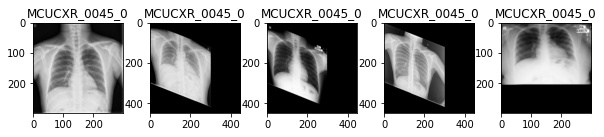

In [43]:
import glob
from PIL import Image
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob('base_dir/train_dir/Normal/augmented_image_*'):
    images.append(np.asarray(Image.open(f)))
    #images = Image.fromarray(f)

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(1, 5, figsize=(10, 50))
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

# This is for displaying the names

for i in range(5):
    for filename in os.listdir('base_dir/train_dir/Normal/'):
      ClassName = filename[:-4]
      axs[i].imshow(images[i])
      axs[i].set_title(ClassName)
      

To plot the augmented images in Tuberculosis class

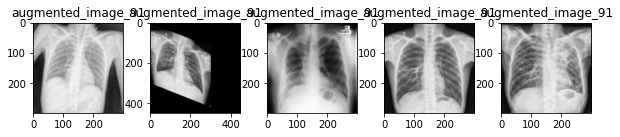

In [44]:
import glob
from PIL import Image
# Put all images in the folder into a list (works)
images = []
for f in glob.iglob('base_dir/train_dir/Tuberculosis/augmented_image_*'):
    images.append(np.asarray(Image.open(f)))
    #images = Image.fromarray(f)

# plot the images (works)
images = np.array(images)
fig, axs = plt.subplots(1, 5, figsize=(10, 50))
fig.subplots_adjust(hspace = .3, wspace=.3)
axs = axs.ravel()

# This is for displaying the names

for i in range(5):
    for filename in os.listdir('base_dir/train_dir/Tuberculosis/'):
      ClassName = filename[:-4]
      axs[i].imshow(images[i])
      axs[i].set_title(ClassName)

In [45]:
# # Augmenting images and creating aug folder to store augmented images 

# class_list = ['Normal','Tuberculosis']

# NUM_AUG_IMAGES_WANTED = 1500 


# for item in class_list:
    
#     # We are creating temporary directories here because we delete these directories later.
#     # create a base dir
#     aug_dir = 'aug_dir'
#     os.mkdir(aug_dir)
#     # create a dir within the base dir to store images of the same class
#     img_dir = os.path.join(aug_dir, 'img_dir')
#     os.mkdir(img_dir)

#     # Choose a class
#     img_class = item

#     # list all images in that directory
#     img_list = os.listdir('base_dir/train_dir/' + img_class)

#     # Copy images from the class train dir to the img_dir e.g. class 'Normal'
#     for fname in img_list:
#             # source path to image
#             src = os.path.join('base_dir/train_dir/' + img_class, fname)
#             # destination path to image
#             dst = os.path.join(img_dir, fname)
#             # copy the image from the source to the destination
#             shutil.copyfile(src, dst)


#     # point to a dir containing the images and not to the images themselves
#     path = aug_dir
#     save_path = 'base_dir/train_dir/' + img_class

#     # Create a data generator
#     datagen = ImageDataGenerator(
#         rotation_range=10,
#         width_shift_range=0.1,
#         height_shift_range=0.1,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         fill_mode='nearest')

#     batch_size = 50

#     aug_datagen = datagen.flow_from_directory(path,
#                                            save_to_dir=save_path,
#                                            save_format='png',
#                                                     target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
#                                                     batch_size=batch_size)
    
    
#     # Generate the augmented images and add them to the training folders
    
    
#     num_files = len(os.listdir(img_dir))
    
#     # this creates a similar amount of images for each class
#     num_batches = int(np.ceil((NUM_AUG_IMAGES_WANTED-num_files)/batch_size))

#     # run the generator and create augmented images
#     for i in range(0,num_batches):

#         imgs, labels = next(aug_datagen)
        
#     # delete temporary directory with the raw image files
#     shutil.rmtree('aug_dir')

In [46]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('base_dir/train_dir/Normal')))
print(len(os.listdir('base_dir/train_dir/Tuberculosis')))

1846
1836


In [90]:
#check how many val images we have in each folder.

print(len(os.listdir('base_dir/val_dir/Normal')))
print(len(os.listdir('base_dir/val_dir/Tuberculosis')))

61
59


# Hand Engineered Feature - HOG

In [48]:
#importing required libraries
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
import glob
import skimage

def loadImages(path):
    '''
        parameters
        ----------
        path : input path of the images
        
        returns
        -------
        loadedImages : list of loaded images 
    '''
    sample = []
    
    for filename in glob.glob(path):
        
        img = cv2.imread(filename)
        img = skimage.transform.resize(img, (299, 299, 3))   
        
        fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
        
        
        #IMG = np.array(img,dtype=np.float64)
        
        IMG = hog_image
        sample.append(IMG)
        
        
    return sample

In [50]:
# our code for train and test paths

train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

In [51]:
# train_path1 = 'base_dir/train_dir/Normal/*.png'
# train_path2 = 'base_dir/train_dir/Tuberculosis/*.png'

# valid_path1 = 'base_dir/val_dir/Normal/*.png'
# valid_path2 = 'base_dir/val_dir/Tuberculosis/*.png'

In [52]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

train_path1 = 'base_dir/train_dir/Normal/*.png'
train_path2 = 'base_dir/train_dir/Tuberculosis/*.png'
train_path3 = 'base_dir/train_dir/Normal/augmented_image_*'
train_path4 = 'base_dir/train_dir/Tuberculosis/augmented_image_*'

valid_path1 = 'base_dir/val_dir/Normal/*.png'
valid_path2 = 'base_dir/val_dir/Tuberculosis/*.png'

In [53]:
# train_N = loadImages(train_path1)
# train_TB = loadImages(train_path2)

# valid_N = loadImages(valid_path1)
# valid_TB = loadImages(valid_path2)

In [54]:
# 758 s
train_N_aug = loadImages(train_path3) 
train_TB_aug= loadImages(train_path4)

In [55]:
valid_N = loadImages(valid_path1)
valid_TB = loadImages(valid_path2)

In [56]:
#%% CREATION OF DATASETS FOR FEATURE EXTRACTION


df_train_N_aug = pd.DataFrame({'image':train_N_aug, 'label': 'Normal'})
df_train_TB_aug = pd.DataFrame({'image':train_TB_aug, 'label': 'Tuberculosis'})


df_valid_N = pd.DataFrame({'image':valid_N, 'label': 'Normal'})
df_valid_TB = pd.DataFrame({'image':valid_TB, 'label': 'Tuberculosis'})

# Visualizing HOG features

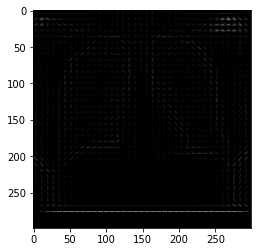

In [57]:
plt.imshow(df_train_N_aug['image'][5],cmap=plt.cm.gray)

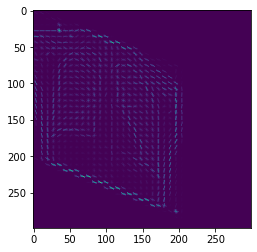

In [58]:
plt.imshow(df_train_TB_aug['image'][50])

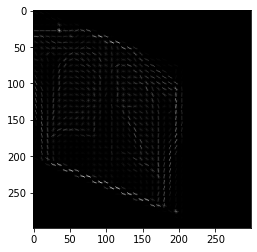

In [59]:
plt.imshow(df_train_TB_aug['image'][50],cmap=plt.cm.gray)

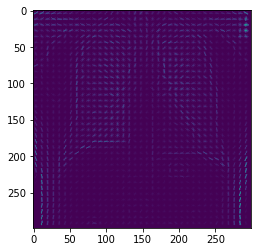

In [60]:
plt.imshow(df_valid_N['image'][50])

In [61]:
temp_N = df_train_N_aug.head(9)

In [62]:
temp_N.shape

(9, 2)

In [63]:
temp_TB = df_train_TB_aug.head(9)
temp_TB.shape

(9, 2)

In [64]:
final_data = [temp_N,temp_TB,df_train_N_aug, df_train_TB_aug, df_valid_N, df_valid_TB]
final_data = pd.concat(final_data)

print("Entire data size:",final_data.shape)

Entire data size: (3140, 2)


In [65]:
#%% TRAIN LABEL SEPARATION

train_data = final_data['image']
labels = final_data['label']

In [66]:
#%% LOOKING AT THE AMOUNT OF ITEMS PER CLASS 

from collections import Counter
print("Labels Count:",Counter(np.array(labels)))

Labels Count: Counter({'Normal': 1571, 'Tuberculosis': 1569})


In [67]:
# ENCODING the LABELS

le = LabelEncoder()

final_data['label'] = le.fit_transform(final_data['label'])
final_data.head()

,image,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [68]:
# for 3140 by adding 18 temp train
#%% SPLITTING INTO TRAIN AND TEST SET, TRAIN SET WILL BE FURTHER SPLIT INTO TRAIN AND VALIDATION SET
X_train, X_test, y_train, y_test = train_test_split(train_data, final_data['label'],
                                                  test_size = 0.2,
                                                  stratify = final_data['label'],
                                                  shuffle = True,
                                                  random_state = 42)

print('length X_train:', len(X_train))
print('length y_train:', len(y_train))

print('length X_test:',  len(X_test))
print('length y_test:', len(y_test))

length X_train: 2512
length y_train: 2512
length X_test: 628
length y_test: 628


In [69]:
X_train.shape

(2512,)

In [70]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [71]:
x_train= np.empty((len(X_train),X_train[0].shape[0],X_train[0].shape[1]))  
for i,x in enumerate(X_train):
    x_train[i]=X_train[i]
print(x_train.shape)

(2512, 299, 299)


In [72]:
x_test= np.empty((len(X_test),X_test[0].shape[0],X_test[0].shape[1])) # ,X_test[0].shape[2]
for i,x in enumerate(X_test):
    x_test[i]=X_test[i]
print(x_test.shape)

(628, 299, 299)


# reshaping x-train and x_test for Logistic Regression model as it takes only 2D data.

## in our case 
nsamples = 2512
nx= 299
ny =299

for x_test
nsamples = 628
nx= 299
ny = 299

In [73]:
x_train = x_train.reshape((2512, 299*299))

In [74]:
## reshaping x_test

In [75]:
x_test = x_test.reshape((628, 299*299))

# Training Logistic Regression Model with Hand Engineered HOG features

In [76]:
import os
import gc
import re
import cv2
import sys
import glob
import keras

import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style  as style

from tqdm  import tqdm
from sklearn.metrics     import accuracy_score, roc_auc_score
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import train_test_split


In [77]:
# Create Logistic Regression
logit_model = LogisticRegression(random_state=451, solver='lbfgs', max_iter=1000)
logit_model.fit(x_train, y_train)

LogisticRegression(max_iter=1000, random_state=451)

In [78]:
# The predict() method
# All supervised estimators in scikit-learn implement the predict() method that can be executed on a trained model in order to predict the actual label (or class) over a new set of data.

In [79]:
logit_preds_HOG_val_pred = logit_model.predict(x_test)
logit_preds_HOG_val_pred 

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,

In [80]:
len(logit_preds_HOG_val_pred)

628

In [81]:
# predict_proba method returns the class probabilities for each data point.
logit_preds_prob_HOG_val  = logit_model.predict_proba(x_test)
logit_preds_prob_HOG_val 

array([[0.19284642, 0.80715358],
       [0.9378059 , 0.0621941 ],
       [0.23461089, 0.76538911],
       ...,
       [0.81392606, 0.18607394],
       [0.10688742, 0.89311258],
       [0.1525434 , 0.8474566 ]])

In [82]:
# here is the Probability for HOG features P_hog
P_hog = logit_preds_prob_HOG_val
P_hog

array([[0.19284642, 0.80715358],
       [0.9378059 , 0.0621941 ],
       [0.23461089, 0.76538911],
       ...,
       [0.81392606, 0.18607394],
       [0.10688742, 0.89311258],
       [0.1525434 , 0.8474566 ]])

In [83]:
type(P_hog)

numpy.ndarray

In [84]:
P_hog.shape

(628, 2)

In [85]:
len(P_hog)

628

In [86]:
logit_model.score(x_train, y_train)

0.9621815286624203

In [87]:
logit_model.score(x_test, y_test)

0.9331210191082803

## Saving Logistic Regression Classifier predictions for HOG features as a dataframe

In [88]:
df_logit_preds_HOG_val_pred  = pd.DataFrame(logit_preds_HOG_val_pred, columns =['pred_class_LogisticRegClf'])
df_logit_preds_HOG_val_pred.to_csv('pred_class_LogisticRegClf.csv', index=None)

# Saving Logistic Regression Classifier predictions for HOG features as npy file 

In [89]:
np.save('logit_preds_HOG_val_pred.npy', logit_preds_HOG_val_pred)

# Saving Logistic Regression Classifier predictions Probability for HOG features as npy file 

In [91]:
np.save('logit_preds_prob_HOG_val.npy', logit_preds_prob_HOG_val)